- [x] why do S11 and S22 response not seem to downshift with depth?
    - `"I am not sure why with depth it does not downshift; that's certainly counter-intuitive; I would check the data once more"`
- [x] are S11 and S22 close enough for the data to be considered calibrated for the cables?
    - `"they look calibrated but a deviation of more than 3dB suggests somewhat bad"`
- [x] where to get the Greenland refractive index model?
    - https://arxiv.org/abs/2304.06181
        - n=1.778 +/- 0.006
    - https://radio.uchicago.edu/wiki/images/6/62/20221121_Ice-model-Greenland.pdf
        - n(z) = 1 + 0.845 p(z)
        - p(z) = 917kg/m^3
- [x] verify the math looks right to Mohammad
- [ ] what frequency should I use as a reference for the RVEL calculation?
- [ ] what is the antenna impedance?
    - assuming 50 Ohms for now
- [ ] what is the distance between the antennas/holes?
- [ ] what are the NuRadioMC hardcoded values?


 ### Mohammad recipe for converting S21 to RVEL

# $\mathcal{H}_i(w) = \lambda \sqrt{\frac{\mathcal{R}(Z_A)}{\pi Z_f} \frac{G_i(w)}{n}}$

where

# $G_i(w) = \frac{4 \pi R}{\lambda} |S_{21}(w)|$

and

$w = 0$ because the antennas were co-lowered

substituting $G_i(w)$ into the equation gives us:

# $\mathcal{H}_i(w) = \lambda \sqrt{\frac{\mathcal{R}(Z_A)}{\pi Z_f} \frac{\frac{4 \pi R}{\lambda} |S_{21}(w)|}{n}}$

which simplifies to:

$\mathcal{H}_i(w) = \lambda \sqrt{\frac{\mathcal{R}(Z_A)}{Z_f} \frac{4R}{\lambda n} |S_{21}(w)|}$

- $\mathcal{H}_i(w)$ is the RVEL, Realized Vector Effective Length, at frequency $w$
- $\lambda$ is the wavelength
- $Z_A$ is the complex antenna impedance
- $\mathcal{R}(Z_A)$ is the real part of the antenna impedance
- $Z_f$ is the free space impedance, $Z_f = 377 \Omega$
- $R$ is the distance between the antennas
- $n$ is the refractive index of the medium between the antennas
- $S_{21}(w)$ is the S-parameter at frequency $w$
- $w = 0$ because the antennas were co-lowered

### coordinates and conventions
- The zenith/theta angle is defined with respect to z axis
    - 0° is upwards, 90° is horizontal, 180° is downwards
- The azimuth/phi angle is counting northwards from East
    - 0° is East, 90° is North, 180° is West, 270° is South

In [1]:
import skrf as rf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from scipy.ndimage import gaussian_filter1d


In [2]:
# display plots in notebook
%matplotlib inline
import matplotlib.pyplot as plt

rf.stylely()

In [3]:
data_25m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_25m.s2p')
# print the details of the network
print(data_25m)


2-Port Network: 'Aug4_hpol_down_25m',  2000000.0-1000000000.0 Hz, 4001 pts, z0=[50.+0.j 50.+0.j]


In [4]:
data_1m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_1m.s2p')
s11_1m_db = data_1m.s_db[:, 0, 0]
s12_1m_db = data_1m.s_db[:, 0, 1]
s21_1m_db = data_1m.s_db[:, 1, 0]
s22_1m_db = data_1m.s_db[:, 1, 1]

data_25m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_25m.s2p')
s11_25_db = data_25m.s_db[:, 0, 0]
s12_25_db = data_25m.s_db[:, 0, 1]
s21_25_db = data_25m.s_db[:, 1, 0]
s22_25_db = data_25m.s_db[:, 1, 1]

data_50m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_50m.s2p')
s11_50_db = data_50m.s_db[:, 0, 0]
s12_50_db = data_50m.s_db[:, 0, 1]
s21_50_db = data_50m.s_db[:, 1, 0]
s22_50_db = data_50m.s_db[:, 1, 1]

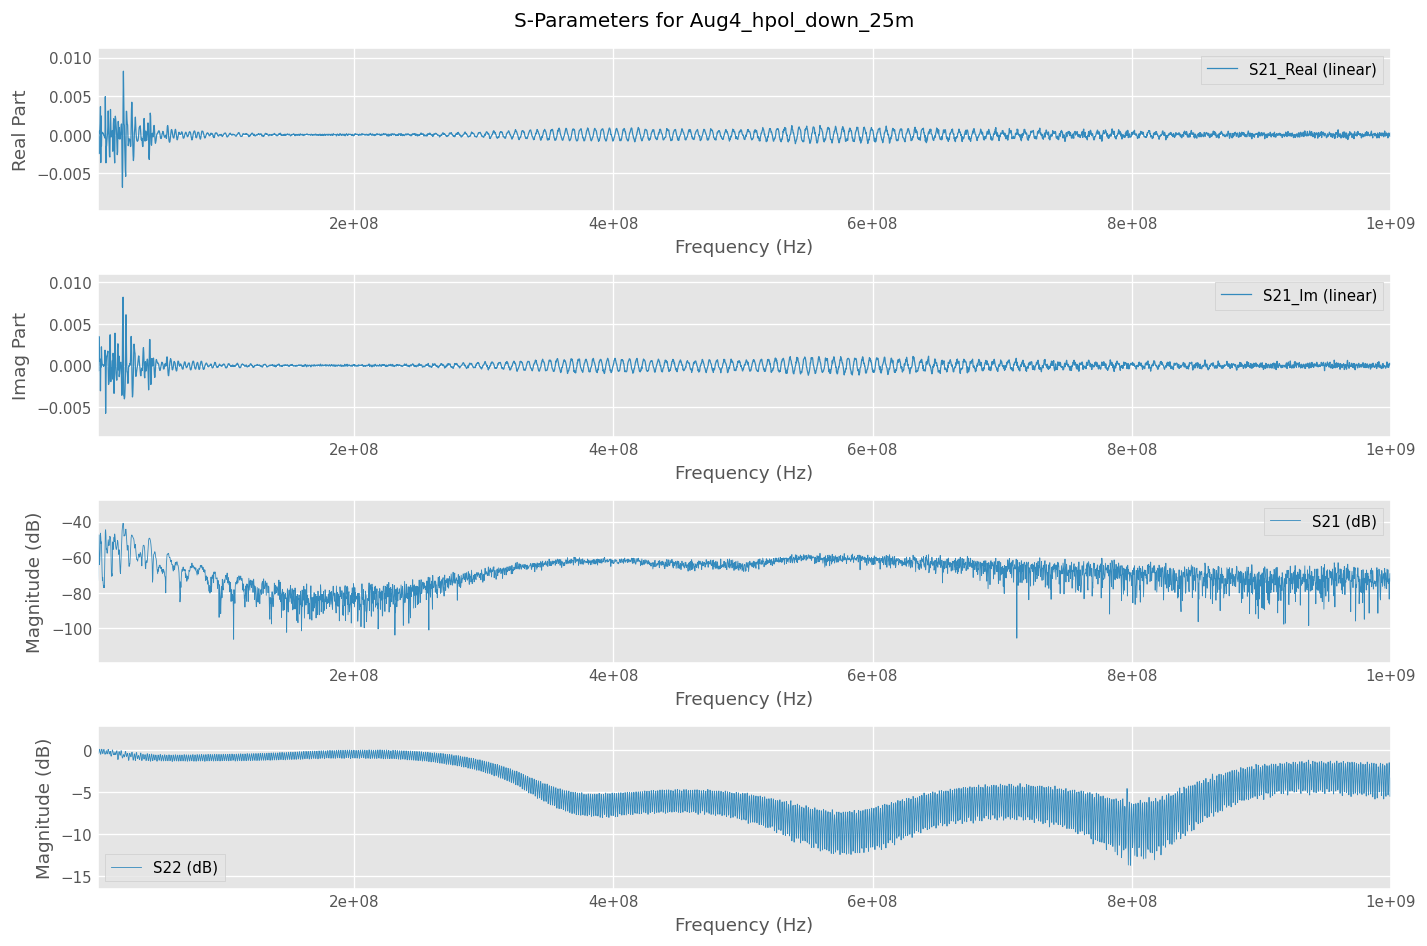

In [5]:
figure (figsize=(12, 8))
plt.suptitle('S-Parameters for Aug4_hpol_down_25m')
# S21 real part
plt.subplot(4, 1, 1)
data_25m.plot_s_re(1, 0, label='S21_Real (linear)', linewidth=0.75)

# S21 imaginary part
plt.subplot(4, 1, 2)
data_25m.plot_s_im(1, 0, label='S21_Im (linear)', linewidth=0.75)

# S21 magnitude in dB
plt.subplot(4, 1, 3)
data_25m.plot_s_db(1, 0, label='S21 (dB)', linewidth=0.5)

# S22 magnitude in dB
plt.subplot(4, 1, 4)
data_25m.plot_s_db(1, 1, label='S22 (dB)', linewidth=0.5)

plt.tight_layout()

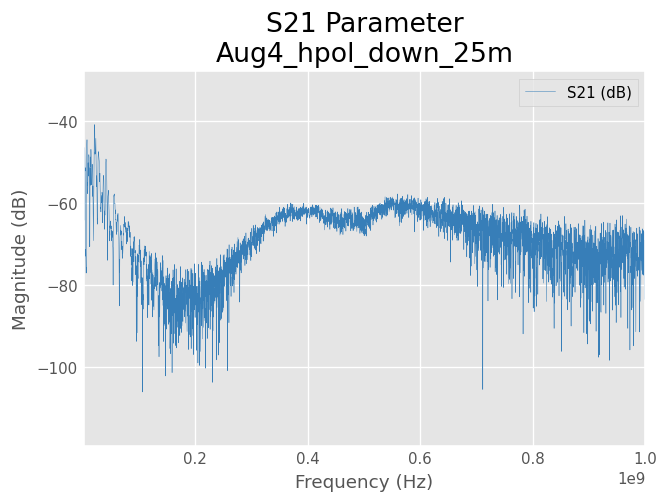

In [14]:
# plot the S21
plt.figure()
plt.plot(data_25m.frequency.f, data_25m.s_db[:, 1, 0], label='S21 (dB)', linewidth=.3)
plt.title('S21 Parameter\nAug4_hpol_down_25m')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.savefig('Images/S21 Parameter_Aug4_hpol_down_25m.png', dpi=600, bbox_inches='tight')

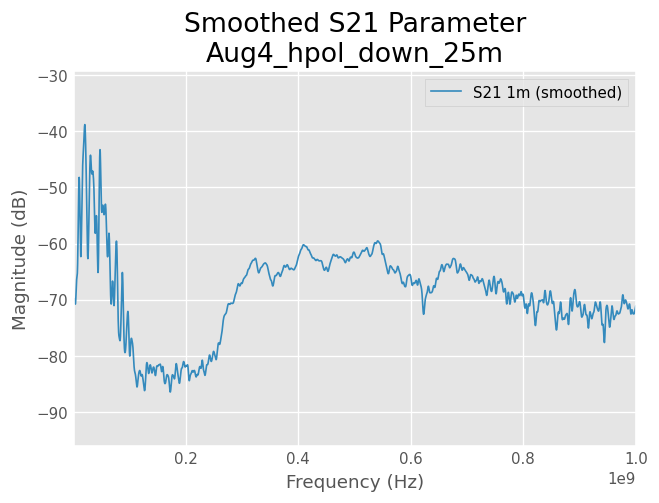

In [7]:
# smooth and plot the S21 curve
sigma = 5  # Standard deviation for Gaussian kernel
s21_1m_db_smooth = gaussian_filter1d(s21_1m_db, sigma)
s21_25_db_smooth = gaussian_filter1d(s21_25_db, sigma)
s21_50_db_smooth = gaussian_filter1d(s21_50_db, sigma)

plt.figure()
plt.plot(data_1m.frequency.f, s21_1m_db_smooth, label='S21 1m (smoothed)')
plt.title('Smoothed S21 Parameter\nAug4_hpol_down_25m')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.savefig('Images/Smoothed S21 Parameter_Aug4_hpol_down_25m.png', dpi=600, bbox_inches='tight')

In [8]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'])  # set colorblind cycle

In [9]:
# # plot the S11 curves for 15, 30, and 45m
#
# # get the data
# data_15m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_15m.s2p')
# s11_15m_db = data_15m.s_db[:, 0, 0]
# s22_15m_db = data_15m.s_db[:, 1, 1]
# data_30m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_30m.s2p')
# s11_30m_db = data_30m.s_db[:, 0, 0]
# s22_30m_db = data_30m.s_db[:, 1, 1]
# data_45m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_45m.s2p')
# s11_45m_db = data_45m.s_db[:, 0, 0]
# s22_45m_db = data_45m.s_db[:, 1, 1]
#
#
# # smooth the S11 curves using gaussian filter
# sigma = 5  # Standard deviation for Gaussian kernel
# s11_15m_db_smooth = gaussian_filter1d(s11_15m_db, sigma)
# s11_30m_db_smooth = gaussian_filter1d(s11_30m_db, sigma)
# s11_45m_db_smooth = gaussian_filter1d(s11_45m_db, sigma)
#
# # plot the smoothed S11 curves
# plt.figure(figsize=(12, 3))
# plt.plot(data_15m.frequency.f, s11_15m_db_smooth, label='S11 15m (smoothed)', linewidth=.3)
# plt.plot(data_30m.frequency.f, s11_30m_db_smooth, label='S11 30m (smoothed)', linewidth=.3)
# plt.plot(data_45m.frequency.f, s11_45m_db_smooth, label='S11 45m (smoothed)', linewidth=.3)
# plt.title('Smoothed S11 Parameter\nAug4_hpol_down 15m, 30m, 45m')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Magnitude (dB)')
# plt.legend()
# plt.savefig('Images/Smoothed S11 Parameters_Aug4_hpol_down_15_30_45m.png', dpi=600, bbox_inches='tight')

## $\mathcal{H}_i(w) = \lambda \sqrt{\frac{\mathcal{R}(Z_A)}{Z_f} \frac{4R}{\lambda n} |S_{21}(w)|}$

- $\mathcal{H}_i(w)$ is the RVEL, Realized Vector Effective Length, at frequency $w$
- $\lambda$ is the wavelength
- $Z_A$ is the complex antenna impedance
- $\mathcal{R}(Z_A)$ is the real part of the antenna impedance
- $Z_f$ is the free space impedance, $Z_f = 377 \Omega$
- $R$ is the distance between the antennas
- $n$ is the refractive index of the medium between the antennas
- $S_{21}(w)$ is the S-parameter at frequency $w$
- $w = 0$ because the antennas were co-lowered

In [10]:
# Constants we know
Z_f = 377  # Free space impedance in Ohms
n = 1.778  # Refractive index of the medium (Greenland ice)

# Constants we need to check
R = 1.0  # Distance between antennas in meters
Z_A = 50.0  # Antenna impedance in Ohms (assumed, needs verification)

# Constants we might want to change
freq = 500e6  # Frequency in Hz
# wavelength = 3e8 / freq  # Wavelength in meters
# Calculate the real part of the antenna impedance
R_A = Z_A  # Assuming the antenna impedance is purely resistive for simplicity

In [11]:
# calculate the gain G_i for each S21 value
# def get_G_i(S21, R, wavelength):
# def get_G_i(S21, R):
def get_G_i(network, R):
    S21_lin = np.abs(network.s[:, 1, 0])  # Use magnitude of S21 in linear scale
    wavelength = 3e8 / network.frequency.f  # Wavelength in meters
    G = (4 * np.pi * R / wavelength) * S21_lin
    return G

# Calculate G_i for each S21 value
# G_1m = get_G_i(data_1m.s[:, 1, 0], R)
# G_25m = get_G_i(data_25m.s[:, 1, 0], R)
# G_50m = get_G_i(data_50m.s[:, 1, 0], R)
G_25m = get_G_i(data_25m, R)

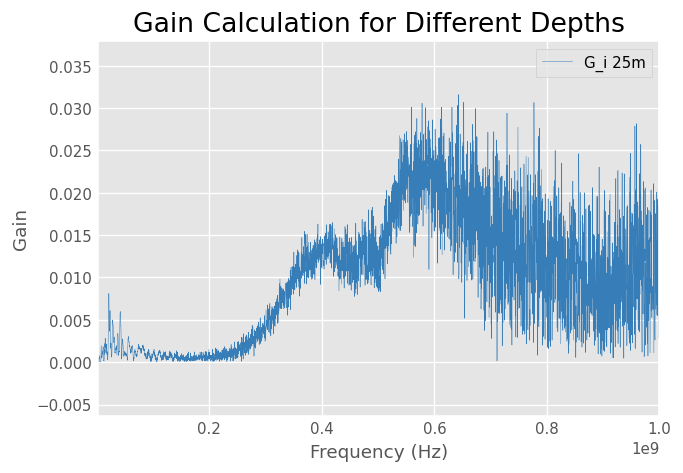

In [12]:
# plt the gain G_i for each S21 value
plt.figure()
# plt.plot(data_1m.frequency.f, G_1m, label='G_i 1m', linewidth=.3)
plt.plot(data_25m.frequency.f, G_25m, label='G_i 25m', linewidth=.3)
# plt.plot(data_50m.frequency.f, G_50m, label='G_i 50m', linewidth=.3)
plt.title('Gain Calculation for Different Depths')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
# set log scale for y-axis
# plt.yscale('log')
plt.legend()
plt.savefig('Images/Gain_Calculation_Aug4_hpol_down.png', dpi=600, bbox_inches='tight')
plt.show()

In [13]:
# smooth and plot the gain curves
sigma = 20  # Standard deviation for Gaussian kernel
G_1m_smooth = gaussian_filter1d(G_1m, sigma)
G_25m_smooth = gaussian_filter1d(G_25m, sigma)
G_50m_smooth = gaussian_filter1d(G_50m, sigma)

# put the gain in dB
# G_1m_smooth_db = 20 * np.log10(G_1m_smooth)
# G_25m_smooth_db = 20 * np.log10(G_25m_smooth)
# G_50m_smooth_db = 20 * np.log10(G_50m_smooth)

# Plot the smoothed gain results
plt.figure(figsize=(8, 3))
# plt.plot(data_1m.frequency.f, G_1m_smooth_db, label='G_i 1m (smoothed)')
plt.plot(data_25m.frequency.f, G_25m_smooth, label='G_i 25m (smoothed)')
# plt.plot(data_50m.frequency.f, G_50m_smooth_db, label='G_i 50m (smoothed)')
plt.title('Smoothed Gain Calculation for Different Distances')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.legend()


NameError: name 'G_1m' is not defined

In [13]:
# calculate the RVEL for each S21 value
# def get_RVEL(wavelength, Z_A, Z_f, G_i, n):
def get_RVEL(Z_A, Z_f, G_i, n):
    wavelength = 3e8 / data_1m.frequency.f  # Wavelength in meters
    RVEL = wavelength * np.sqrt((R_A / np.pi * Z_f * n) * G_i)
    # RVEL = wavelength * np.sqrt((Z_A / Z_f) * (4 * R / (wavelength * n)) * G_i)
    return RVEL
# Calculate RVEL for each G_i value
# RVEL_1m = get_RVEL(wavelength, Z_A, Z_f, G_1m, n)
# RVEL_25m = get_RVEL(wavelength, Z_A, Z_f, G_25m, n)
# RVEL_50m = get_RVEL(wavelength, Z_A, Z_f, G_50m, n)
RVEL_1m = get_RVEL(Z_A, Z_f, G_1m, n)
RVEL_25m = get_RVEL(Z_A, Z_f, G_25m, n)
RVEL_50m = get_RVEL(Z_A, Z_f, G_50m, n)

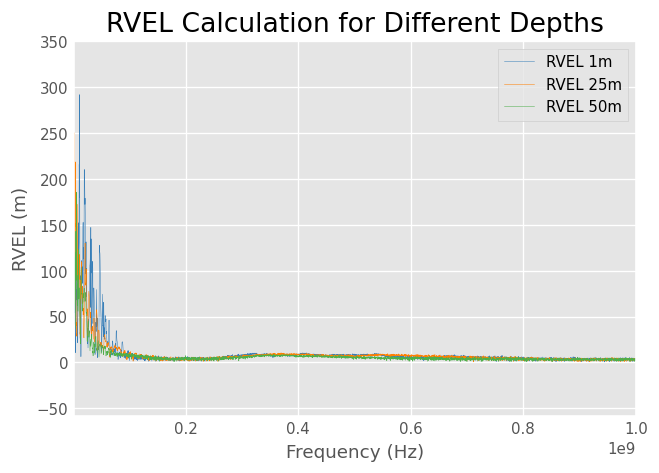

In [23]:
# Plot the RVEL results
plt.figure()
plt.plot(data_1m.frequency.f, RVEL_1m, label='RVEL 1m', linewidth=.3)
plt.plot(data_25m.frequency.f, RVEL_25m, label='RVEL 25m', linewidth=.3)
plt.plot(data_50m.frequency.f, RVEL_50m, label='RVEL 50m', linewidth=.3)
plt.title('RVEL Calculation for Different Depths')
plt.xlabel('Frequency (Hz)')
plt.ylabel('RVEL (m)')
plt.legend()
plt.savefig('Images/RVEL_Calculation_Aug4_hpol_down.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# smooth the RVEL curves
sigma = 5  # Standard deviation for Gaussian kernel
RVEL_1m_smooth = gaussian_filter1d(RVEL_1m, sigma)
RVEL_25m_smooth = gaussian_filter1d(RVEL_25m, sigma)
RVEL_50m_smooth = gaussian_filter1d(RVEL_50m, sigma)
# Plot the smoothed RVEL results
plt.figure(figsize=(12, 3))
plt.plot(data_1m.frequency.f, RVEL_1m_smooth, label='RVEL 1m (smoothed)', linewidth=.3)
plt.plot(data_25m.frequency.f, RVEL_25m_smooth, label='RVEL 25m (smoothed)', linewidth=.3)
plt.plot(data_50m.frequency.f, RVEL_50m_smooth, label='RVEL 50m (smoothed)', linewidth=.3)
plt.title('Smoothed RVEL Calculation for Different Distances')
plt.xlabel('Frequency (Hz)')
plt.ylabel('RVEL (m)')
plt.legend()
plt.savefig('Images/Smoothed_RVEL_Calculation_Aug4_hpol_down.png', dpi=600, bbox_inches='tight')